In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import calendar
import datetime as dt
from itertools import chain
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
# -- STORE ALL FITBIT DATA INTO LISTS OF SHEET --
xls_files = glob.glob('Fitbit/*.xls')

## Functions

In [3]:
def add_weekday(df, not_index=0):
    """Add day of week column"""
    
    # -- USE DATAFRAME'S INDEX IF 'not_index' = 1, OTHERWISE USE DATAFRAME'S 'Date' COLUMN --
    col = df.index
    if not_index:
        col = df['Date']
    
    # -- DETERMINE THE DAY OF WEEK FROM THE DATE AND STORE IN A LIST (USED TO ADD AS A COLUMN TO THE DATAFRAME) --
    weekday = []
    for date in col:
        #weekday.append(datetime.strptime(str(date), '%Y-%m-%d').strftime('%A'))
        weekday.append(calendar.day_name[date.weekday()])
    df.loc[:, 'Weekday'] = weekday
    
    
def to_num(df, list_of_cols):
    """Remove commas and convert values to a numeric data type"""
    
    for col in list_of_cols:
        #df[col] = df[col].str.replace(',', '')
        df[col] = df[col].str.replace('\D', '', regex=True)
        df[col] = pd.to_numeric(df[col])
        

def to_date(df, list_of_col):
    """Convert columns into datetime type"""
    
    for col in list_of_col:
        df[col] = pd.to_datetime(df[col])
        
        
def replace_outliers(df):
    """Replace outliers with mean"""
    
    for col in df.columns:
        mean = df[col].mean()
        std = df[col].std()
        df[col] = df[col].mask(((df[col] - mean).abs() > 2 * std), mean)

### Function for wrangling sleep data

In [4]:
def sort_sleep_data(list_of_df):
    """Sort sleep data by date"""
    
    for i in range(len(list_of_df)):
        list_of_df[i].sort_values(by='Start Time', ascending=True, inplace=True)

### Functions for wrangling food and macros data

In [5]:
def flatten_list(l):
    """Flatten a list"""
    
    return list(chain(*l))


def get_sheetnames_and_dates(excel_file):
    """Only get sheet names and dates for days where food data is entered"""
    """Returns: 2 lists (sheet names & dates)"""
    
    monthly_calories = pd.ExcelFile(excel_file).parse('Foods')

    dates = []
    sheet_names = []
    
    # -- GET SHEET NAMES AND DATES ONLY FOR THE DAYS WHERE INFO ABOUT FOOD INTAKE IS ENTERED --
        # -- daily[0]: date --
        # -- daily[1]: calories --
    for daily in monthly_calories.values:
        if str(daily[1]) != '0':
            dates.append(datetime.strptime(daily[0], '%Y-%m-%d').date())
            foodLogSheetName = 'Food Log ' + daily[0].replace('-', '')
            sheet_names.append(foodLogSheetName)
    return sheet_names, dates


def remove_empty_rows(xls, sheet_list):
    """Converting data in labeled table format to dataframe format"""
    """Returns: dataframe without unnecessary data"""
    
    df_list = [pd.read_excel(xls, sheet_name=sheet) for sheet in sheet_list]

    # -- REMOVING UNNECESSARY ROWS & FILLING IN 'MISSING' DATA --
    for df in df_list:
        df.dropna(how='all', inplace=True)
        df['Meal'] = df['Meal'].fillna(method='ffill')
        df.reset_index(drop=True, inplace=True)
        
    return df_list


def get_food_and_macros(food_list, dates_list):
    """Get macros information into desirable dataset format"""
    """Returns: 2 dataframes (one with food consumption data & one with daily macros info)"""

    macros_df = pd.DataFrame()
    all_food_df = pd.DataFrame()
    all_macros_df = pd.DataFrame()
    
    # -- SPLITTING DATA INTO TWO DIFFERENT DATAFRAMES --
    for ind, (df, date) in enumerate(zip(food_list, dates_list)):
        
        index_of_macros = []

        # -- STORE INDEX OF ROWS THAT HAVE MACROS DATA --
        for i in df.index:
            if df['Meal'][i] == 'Daily Totals':
                index_of_macros.append(i)

        # -- EXTRACT MACROS DATA FROM THE DATAFRAME. CREATE & STORE MACROS DATA IN A NEW DATAFRAME --
        macros_df = df.iloc[index_of_macros[1]:index_of_macros[-1]+1]
        macros_df['Date'] = date
        macros_df = macros_df.pivot(index='Date', columns='Food', values='Calories')
        all_macros_df = all_macros_df.append(macros_df)

        # -- ADD 'Date' COLUMN TO THE FOOD DATAFRAME --
        food_list[ind]['Date'] = date

        # -- STORE EACH UPDATED FOOD DATAFRAME INTO A NEW DATAFRAME --
        all_food_df = all_food_df.append(food_list[ind].drop(index=index_of_macros).dropna())

    return all_food_df, all_macros_df

## Data wrangling

### Cleaning activities & sleep data

In [6]:
# -- STORING DATA IN EXCEL AS LISTS DATAFRAMES --
list_of_activities_df = [pd.ExcelFile(xls).parse('Activities', index_col=0, parse_dates=True) for xls in xls_files]
list_of_sleep_df = [pd.ExcelFile(xls).parse('Sleep', usecols=':F') for xls in xls_files]

# -- CONCATING ALL FOOD DATAFRAMES INTO ONE BIG DATAFRAME --
activities = pd.concat(list_of_activities_df)

# -- CONCATING ALL SLEEP DATAFRAMES INTO ONE BIG DATAFRAME --
sort_sleep_data(list_of_sleep_df)
sleep = pd.concat(list_of_sleep_df)
sleep.reset_index(drop=True, inplace=True)

# -- GET COLUMNS TO CORRECT TYPE & REMOVING MISSING VALUES --
to_num(activities, ['Calories Burned', 'Steps', 'Minutes Sedentary', 'Activity Calories'])
to_date(sleep, ['Start Time', 'End Time'])
activities = activities[activities['Steps'] != 0]

# -- CREATE A NEW SLEEP DATAFRAME WHERE THERE WILL ONLY BE ONE RECORD FOR EACH DAY --
dates = []
for i in range(len(sleep['Start Time'])):
    date = sleep['Start Time'][i].date()
    time = sleep['Start Time'][i].time()
    # -- BEDTIMES BEFORE 4AM ARE CONSIDERED TO BE PREVIOUS DAY'S SLEEP --
    if time > dt.time(4):
        dates.append(date)
    else:
        dates.append(date - timedelta(1))
sleep['Date'] = dates

daily_sleep = sleep.groupby('Date').sum()
daily_sleep.index = pd.to_datetime(daily_sleep.index)

# -- CREATE ANOTHER SLEEP DATAFRAME WITH NO NAP ENTRIES --
for x in sleep['Start Time']:
    x = x.to_pydatetime()

indices = []
for i, x in enumerate(sleep['Start Time']):
    if (x.time() > dt.time(20)) | (x.time() < dt.time(4)):
        indices.append(i)
        
sleep_night = sleep.loc[indices]
sleep_night = sleep_night.groupby('Date').sum()

# -- REPLACE OUTLIERS WITH MEAN --
replace_outliers(activities)
replace_outliers(daily_sleep)

# -- ADD DAY OF WEEK COLUMN --
add_weekday(activities)
add_weekday(daily_sleep)

### Cleaning food data

In [7]:
# -- GET ALL NECESSARY SHEET NAMES AND DATES --
sheet_names, dates = zip(*[get_sheetnames_and_dates(xls) for xls in xls_files])
dates = [d for d in dates if d]

# -- FIRST STEP IN DATA CLEANING: REMOVING ALL EMPTY ROWS --
list_of_food_df = [remove_empty_rows(xls, monthly_sheets) for xls, monthly_sheets in zip(xls_files, sheet_names) if monthly_sheets]

# -- SECOND STEP IN DATA CLEANING: SPLIT ORIGINAL DATAFRAMES INTO SEPARATE DATAFRAMES --
list_of_food_df, list_of_macros_df = zip(*[get_food_and_macros(monthly_food, date) for monthly_food, date in zip(list_of_food_df, dates)])

macros = pd.concat(list_of_macros_df)
food = pd.concat(list_of_food_df)
food.reset_index(drop=True, inplace=True)

to_num(macros, ['Calories', 'Carbs', 'Fat', 'Fiber', 'Protein', 'Sodium', 'Water'])

add_weekday(macros)
add_weekday(food, 1)

macros.columns = ['Calories (g)', 'Carbs (g)', 'Fat (g)', 'Fiber (g)', 'Protein (g)', 'Sodium (mg)', 'Water (fl oz)', 'Weekday']

In [8]:
sns.set()

## Inferential Statistics

**Significance level** (for all tests): 0.05

---

### Minutes Very Active vs Calories Burned

**Null hypothesis:** There is no correlation between the amount of calories burned and duration of high intensity workouts.

**Alternative hypothesis:** There is a correlation between amount of calories burned and duration of high intensity workouts.

Text(0,0.5,'Calories Burned')

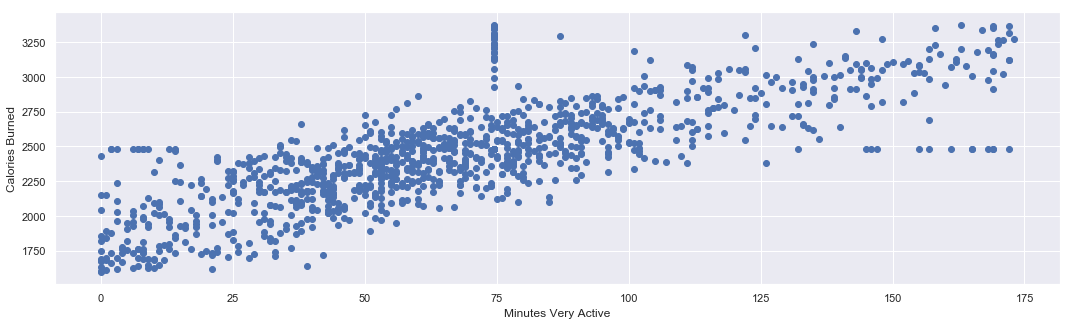

In [9]:
plt.figure(figsize=(18, 5))
plt.scatter('Minutes Very Active', 'Calories Burned', data=activities)

plt.xlabel('Minutes Very Active')
plt.ylabel('Calories Burned')

In [10]:
scipy_r, scipy_p = stats.pearsonr(activities['Minutes Very Active'], \
                                  activities['Calories Burned'])

print("Scipy's correlation coefficient:", scipy_r)
print("Scipy's p-value:", scipy_p)

Scipy's correlation coefficient: 0.7858467996449217
Scipy's p-value: 7.142083581912041e-233


The p-value is extremely small, so the null hypothesis is rejected. In fact, the correlation of 0.79 informs us her very active minutes has a huge impact on the amount of calories Tracy burns.

### Activity Calories vs Carb Intake

**Null hypothesis:** There is no correlation between activity calories and carb intake.

**Alternative hypothesis:** There is a correlation between activity calories and carb intake.

Text(0,0.5,'Activity Calories')

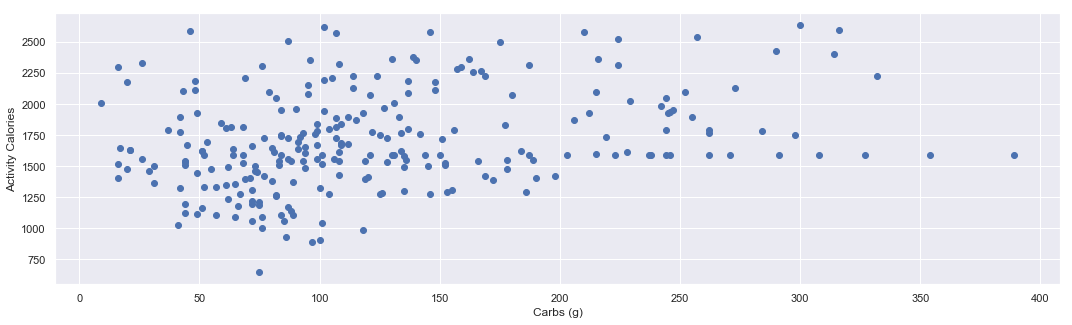

In [11]:
macros.index = pd.to_datetime(macros.index)

df1 = activities.merge(macros.iloc[:, 0:6], left_index=True, right_index=True)
plt.figure(figsize=(18, 5))
plt.scatter('Carbs (g)', 'Activity Calories', data=df1)

plt.xlabel('Carbs (g)')
plt.ylabel('Activity Calories')

In [12]:
scipy_r, scipy_p = stats.pearsonr(df1['Activity Calories'], df1['Carbs (g)'])

print("Scipy's correlation coefficient:", scipy_r)
print("Scipy's p-value:", scipy_p)

Scipy's correlation coefficient: 0.301696397595359
Scipy's p-value: 9.62446731823555e-07


The correlation of 0.3 informs us there is indeed a correlation between the amount of calories Tracy burns through activity and the amount of carbs she consumes. To further support the claim, the p-value is smaller than the significance level, therefore we reject the null hypothesis.

### Number of Awakenings vs Minutes Asleep

**Null hypothesis:** There is no correlation between number of awakenings and minutes asleep.

**Alternative hypothesis:** There is a correlation between number of awakenings and minutes asleep.

Text(0,0.5,'Minutes Asleep')

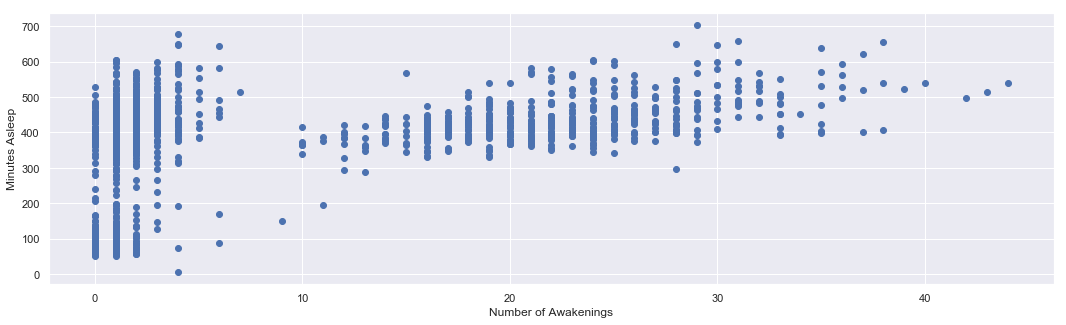

In [13]:
plt.figure(figsize=(18, 5))
plt.scatter('Number of Awakenings', 'Minutes Asleep', data=sleep)

plt.xlabel('Number of Awakenings')
plt.ylabel('Minutes Asleep')

In [14]:
scipy_r, scipy_p = stats.spearmanr(sleep['Number of Awakenings'], sleep['Minutes Asleep'])

print("Scipy's correlation coefficient:", scipy_r)
print("Scipy's p-value:", scipy_p)

Scipy's correlation coefficient: 0.38107089058809945
Scipy's p-value: 1.0564244602304605e-46


There is some positive correlation between number of awakenings and total amount of sleep Tracy gets. The p-value is extremely small so we reject the null hypothesis.

What's quite alarming is how much of a light sleeper Fitbit suggests Tracy to be. Although the correlation suggests she sleeps more as the amount of awakening increases, it may be of interest (for Tracy) to find a solution to help her get better, uninterrupted sleep.